K-MEANS

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns

In [3]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
import seaborn as sns
from scipy.spatial.distance import pdist, squareform

In [4]:
from sklearn.metrics import *
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.neighbors import kneighbors_graph

In [5]:
# import dataset (uso il dataset con i missing value trattati)
df = pd.read_csv("/home/ubuntu/Università/LM/Data mining/trainm.csv", skipinitialspace=True)

Levo le variabili indesiderate

In [6]:
# rileva categorical variables
df.dtypes[df.dtypes.map(lambda x: x == 'object')]

name          object
artists       object
album_name    object
genre         object
dtype: object

In [7]:
# rimuovo le variabili categoriche
dfk = df.drop(['name', 'artists', 'album_name', 'genre'], axis=1)
# rimuovo le variabili binary ed ordinal
dfk.drop(['explicit', 'mode', 'key', 'time_signature'], axis=1, inplace=True)
dfk.dtypes

duration_ms               int64
popularity                int64
danceability            float64
energy                  float64
loudness                float64
speechiness             float64
acousticness            float64
instrumentalness        float64
liveness                float64
valence                 float64
tempo                   float64
features_duration_ms      int64
n_beats                 float64
n_bars                  float64
processing              float64
dtype: object

In [8]:
dfk.head()

,duration_ms,popularity,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,features_duration_ms,n_beats,n_bars,processing
0,241760,46,0.690,0.513,-12.529,0.0975,0.302000,0.53600,0.281,0.6350,142.221,241760,567.0,141.0,1.279305
1,444000,0,0.069,0.196,-24.801,0.0805,0.283000,0.93400,0.360,0.0336,75.596,444000,617.0,155.0,2.367412
2,333506,3,0.363,0.854,-7.445,0.0397,0.000089,0.80000,0.262,0.4890,116.628,333507,652.0,162.0,3.700483
3,269800,23,0.523,0.585,-5.607,0.0765,0.066400,0.00127,0.117,0.3850,140.880,269800,619.0,155.0,1.279305
4,307651,25,0.643,0.687,-11.340,0.0539,0.000576,0.09690,0.299,0.6370,143.956,307652,733.0,183.0,4.067086


Normalizzo con min-max

In [9]:
scaler = MinMaxScaler()
data = scaler.fit_transform(dfk)

Clustering

In [10]:
%%time
sse_list = []
sil_list = []

for k in range(2, 51):
    kmeans = KMeans(init='k-means++', n_clusters=k, n_init=10, max_iter=100)
    kmeans.fit(data)
    sse_list.append(kmeans.inertia_)
    sil_list.append(silhouette_score(data, kmeans.labels_))

CPU times: user 12min 9s, sys: 11min 18s, total: 23min 27s
Wall time: 4min 24s


Scelgo il numero k di cluster

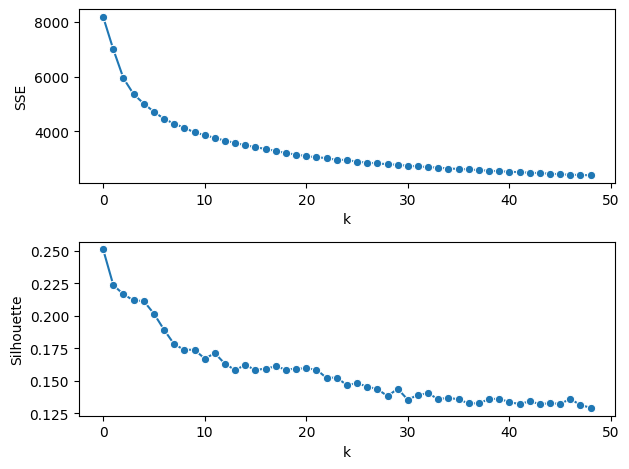

In [11]:
fig, axs = plt.subplots(2) # 1 row, 2 columns

sns.lineplot(x=range(len(sse_list)), y=sse_list, marker='o', ax=axs[0])
axs[0].set(xlabel='k', ylabel='SSE')
sns.lineplot(x=range(len(sil_list)), y=sil_list, marker='o', ax=axs[1])
axs[1].set(xlabel='k', ylabel='Silhouette')

plt.tight_layout() # Adjust the padding between and around subplots

Una volta scelto k, eseguo k-means

In [12]:
kmeans = KMeans(init='k-means++', n_clusters=6, n_init=10, max_iter=100)
kmeans.fit(data)

KMeans(max_iter=100, n_clusters=6, n_init=10)

In [13]:
print('labels', np.unique(kmeans.labels_, return_counts=True))
print('sse', kmeans.inertia_)
print('silhouette', silhouette_score(data, kmeans.labels_))

labels (array([0, 1, 2, 3, 4, 5], dtype=int32), array([3863, 3924, 1605, 1685, 2226, 1697]))
sse 5012.338608935577
silhouette 0.21150183460828398


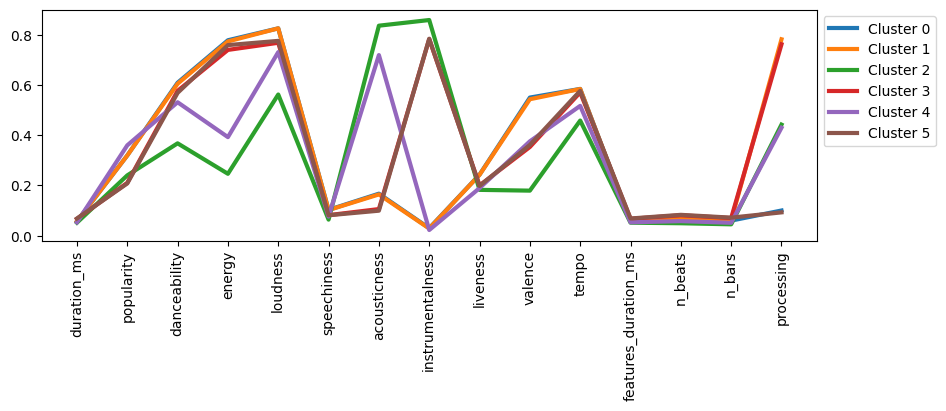

In [14]:
plt.figure(figsize=(10, 3))

for i in range(len(kmeans.cluster_centers_)):
    plt.plot(range(0, 15), kmeans.cluster_centers_[i], label='Cluster %s' % i, linewidth=3)
plt.xticks(range(0, 15), list(dfk.columns))
plt.legend(bbox_to_anchor=(1,1))
plt.grid(axis='y')
plt.xticks(rotation=90)
plt.grid(False)
plt.show()

Analisi PCA per vedere quali sono le componenti che portano più informazioni

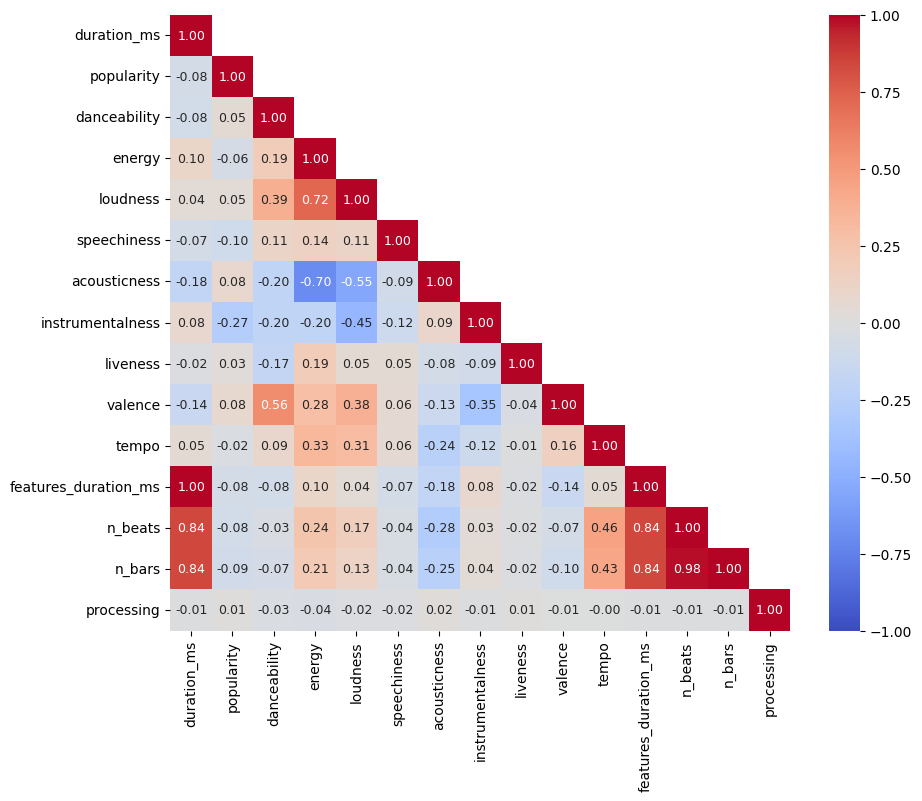

In [15]:
# come prima cosa leviamo le variabili più correlate
# Calcola la matrice di correlazione
correlation_matrix = dfk.corr()

# Crea una maschera per la parte superiore della matrice (sopra la diagonale)
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Imposta la diagonale della maschera su False
np.fill_diagonal(mask, False)

# Crea la heatmap utilizzando seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, cmap='coolwarm', mask=mask, vmin=-1, vmax=1, annot=True, fmt=".2f", annot_kws={'size': 9}, cbar_kws={"shrink": 1.0})
plt.show()

In [16]:
min_vals = np.min(dfk, axis=0)
max_vals = np.max(dfk, axis=0)
dfkn = (dfk - min_vals) / (max_vals - min_vals)

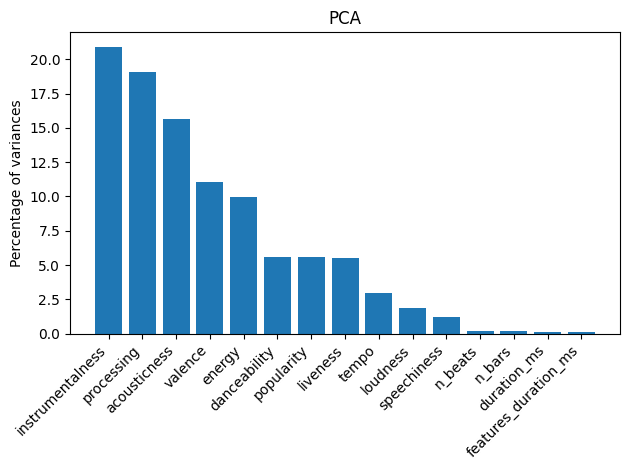

In [17]:
# Calcola la varianza di ogni colonna
variances = dfkn.var()

# Ordina il DataFrame in base alle varianze in ordine decrescente
variances_sorted = variances.sort_values(ascending=False)

# Calcola la varianza totale per normalizzare le percentuali
total_variance = variances_sorted.sum()

# Calcola le percentuali della varianza di ogni colonna
percentage_var = (variances_sorted / total_variance) * 100

# Creazione del grafico
plt.bar(percentage_var.index, percentage_var)
#plt.xlabel('Colonne')
plt.ylabel('Percentage of variances')
plt.title('PCA')
plt.xticks(rotation=45, ha='right')  # Rotazione dei nomi delle colonne per una migliore leggibilità
plt.tight_layout()  # Ottimizza la disposizione del grafico
plt.show()

Notiamo che le componentiche portno più informazioni sono le prime 5, ovvero instrumentalness/processing/acousticness/valence/energy, che tra l'altro non sono correlati ne tra di loro ne con altre variabili 

Visualization

In [18]:
dfkn['label'] = kmeans.labels_
dfkn.head()

,duration_ms,popularity,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,features_duration_ms,n_beats,n_bars,processing,label
0,0.056710,0.489362,0.704082,0.513,0.702298,0.103834,0.303213,0.53600,0.282696,0.638191,0.644920,0.056710,0.077164,0.064977,0.160046,5
1,0.105897,0.000000,0.070408,0.196,0.469376,0.085729,0.284137,0.93400,0.362173,0.033769,0.342800,0.105897,0.083968,0.071429,0.487891,2
2,0.079024,0.031915,0.370408,0.854,0.798793,0.042279,0.000090,0.80000,0.263581,0.491457,0.528865,0.079024,0.088732,0.074654,0.889543,3
3,0.063530,0.244681,0.533673,0.585,0.833678,0.081470,0.066667,0.00127,0.117706,0.386935,0.638839,0.063530,0.084241,0.071429,0.160046,0
4,0.072736,0.265957,0.656122,0.687,0.724866,0.057401,0.000578,0.09690,0.300805,0.640201,0.652788,0.072736,0.099755,0.084332,1.000000,1


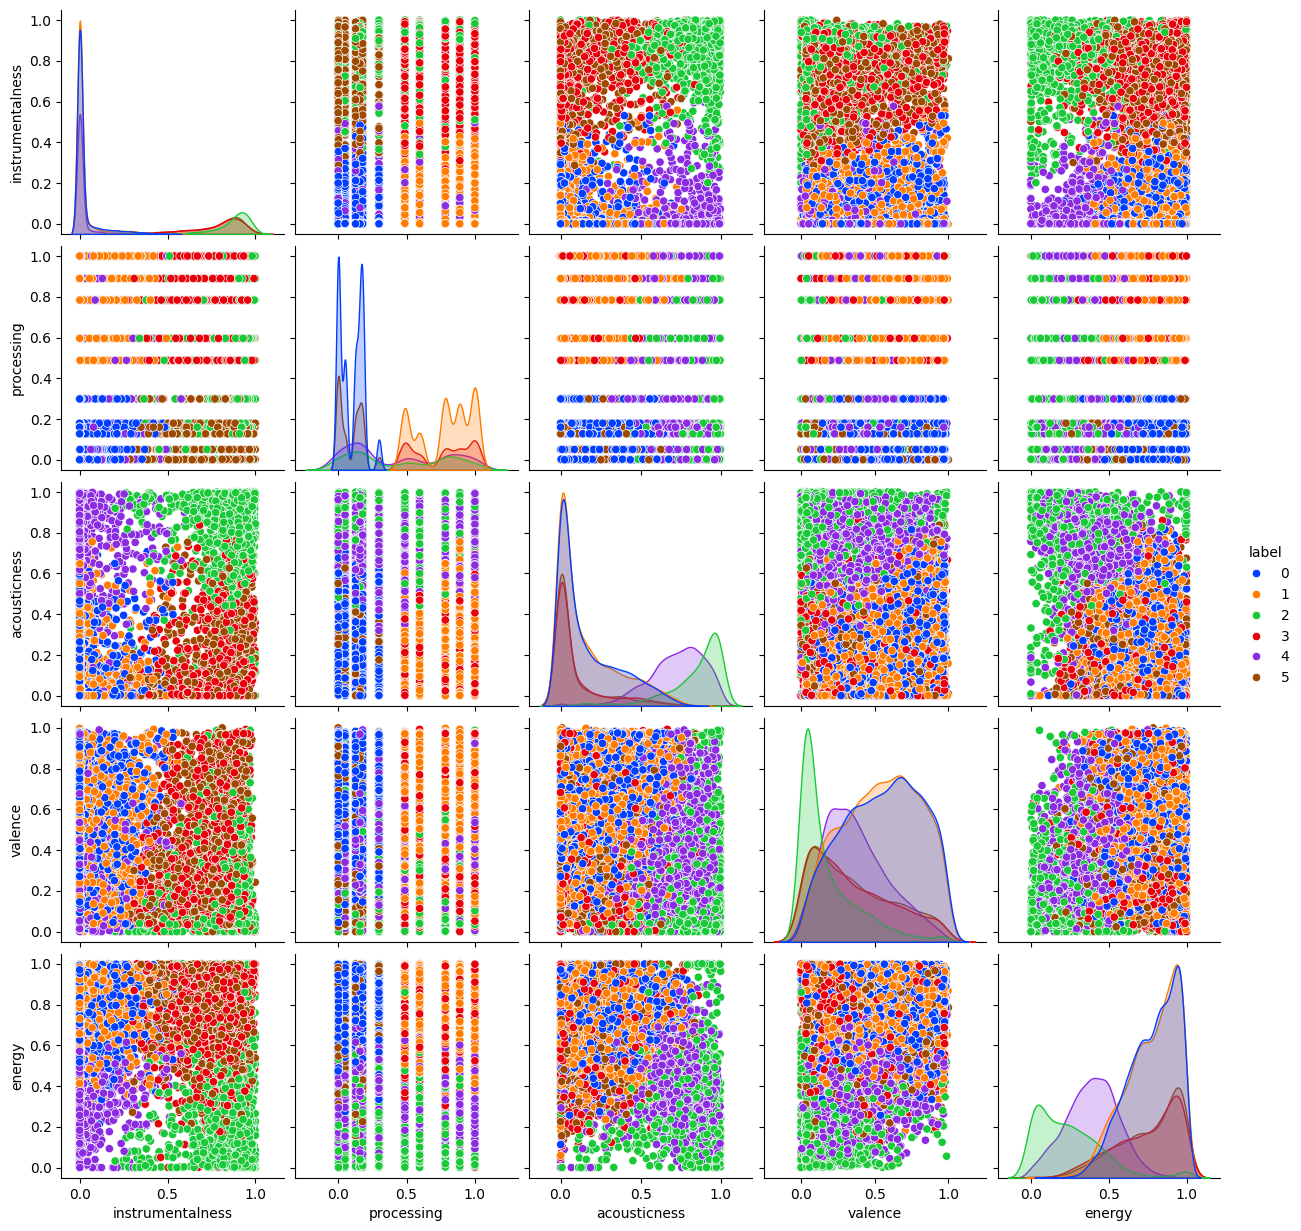

In [19]:
sns.pairplot(dfkn[['instrumentalness', 'processing', 'acousticness', 'valence', 'energy', 'label']], hue='label', diag_kind='kde', palette='bright')    # colorblind
plt.show()

In [30]:
unique_labels = dfkn['label'].unique()
unique_labels = sorted(unique_labels)

for i in unique_labels:
    count = dfkn[dfkn['label'] == i].shape[0]
    print(f"Il numero di elementi con etichetta '{i}' è: {count}")

Il numero di elementi con etichetta '0' è: 3863
Il numero di elementi con etichetta '1' è: 3924
Il numero di elementi con etichetta '2' è: 1605
Il numero di elementi con etichetta '3' è: 1685
Il numero di elementi con etichetta '4' è: 2226
Il numero di elementi con etichetta '5' è: 1697


In [31]:
# Specifica il percorso completo del file
file_path = '/home/ubuntu/Università/LM/Data mining/trainkm.csv'

# Salva il DataFrame nel file CSV
dfkn.to_csv(file_path, index=False)